# Frequently Asked Questions

Here we are attempting to answer some commonly asked questions that appear on Github, and Stack Overflow.

In [2]:
import featuretools as ft
import pandas as pd

## Why does is DFS not creating aggregation features?
One common issue you might run into is with aggregation features. You may have created your entityset, and then applied DFS to create features. However, you may be puzzled why no aggreation features were not created. 
- This is most likely because you have a single table in your entity, and thus DFS is not capable of creating aggregation features. You need at least 2 entities. Featuretools will look for a relationship, and aggregate based on that relationship.

Let's look at a simple example.

In [2]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])
es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id")
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

Notice how we only have 1 entity in our entityset. If we try to create aggregation features on this entityset, it will not be possible because aggregation features need 2 entities. 

In [3]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="transactions")
feature_defs

[<Feature: session_id>,
 <Feature: product_id>,
 <Feature: amount>,
 <Feature: customer_id>,
 <Feature: device>,
 <Feature: zip_code>,
 <Feature: DAY(transaction_time)>,
 <Feature: DAY(session_start)>,
 <Feature: DAY(join_date)>,
 <Feature: DAY(date_of_birth)>,
 <Feature: YEAR(transaction_time)>,
 <Feature: YEAR(session_start)>,
 <Feature: YEAR(join_date)>,
 <Feature: YEAR(date_of_birth)>,
 <Feature: MONTH(transaction_time)>,
 <Feature: MONTH(session_start)>,
 <Feature: MONTH(join_date)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: WEEKDAY(transaction_time)>,
 <Feature: WEEKDAY(session_start)>,
 <Feature: WEEKDAY(join_date)>,
 <Feature: WEEKDAY(date_of_birth)>]

None of the above features are aggregation features. To fix this issue, you can add another entity to your entityset.

There is a couple of ways to add an entity to your entityset:

**Solution #1 - You can add new entity if you have additional data.**

In [4]:
products_df = data["products"]
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=products_df,
                              index="product_id")
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    No relationships

Notice how we now have an additional entity in our entityset.

**Solution #2 - You can normalize an existing entity.**

In [5]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["device", "customer_id", "zip_code", "session_start", "join_date"])
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 6]
  Relationships:
    transactions.session_id -> sessions.session_id

Notice how we have an additional entity in our entityset.

In [6]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="transactions")
feature_defs[:-10]

[<Feature: session_id>,
 <Feature: product_id>,
 <Feature: amount>,
 <Feature: DAY(transaction_time)>,
 <Feature: DAY(date_of_birth)>,
 <Feature: YEAR(transaction_time)>,
 <Feature: YEAR(date_of_birth)>,
 <Feature: MONTH(transaction_time)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: WEEKDAY(transaction_time)>,
 <Feature: WEEKDAY(date_of_birth)>,
 <Feature: sessions.device>,
 <Feature: sessions.customer_id>,
 <Feature: sessions.zip_code>,
 <Feature: sessions.SUM(transactions.amount)>,
 <Feature: sessions.STD(transactions.amount)>,
 <Feature: sessions.MAX(transactions.amount)>,
 <Feature: sessions.SKEW(transactions.amount)>,
 <Feature: sessions.MIN(transactions.amount)>,
 <Feature: sessions.MEAN(transactions.amount)>,
 <Feature: sessions.COUNT(transactions)>]

Now we have sucessfully created aggregation features, a few of which are:
- `<Feature: sessions.SUM(transactions.amount)>`
- `<Feature: sessions.STD(transactions.amount)>`
- `<Feature: sessions.MAX(transactions.amount)>`
- `<Feature: sessions.SKEW(transactions.amount)>`
- `<Feature: sessions.MIN(transactions.amount)>`
- `<Feature: sessions.MEAN(transactions.amount)>`
- `<Feature: sessions.COUNT(transactions)>`

## Why am I getting this error 'Index is not unique' error ?
One error you might run into is with index on your entity. You may have may be trying to create your entity, and running into this error. 
- This is because each entity in your entityset needs a unique index.

Let's look at a simple example.

In [7]:
product_df = pd.DataFrame({'id': [1, 2, 3, 4, 4],
                           'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})
product_df

,id,rating
0,1,3.5
1,2,4.0
2,3,4.5
3,4,1.5
4,4,5.0


Notice how the `id` column has a duplicate index of `4`. If you try to create an entity with this dataframe, you will run into an error.

In [8]:
es = ft.EntitySet(id="product_data")
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=product_df,
                              index="id")

AssertionError: Index is not unique on dataframe (Entity products)

To fix this issue, you can do a couple of things:

**Solution #1 - You can create a unique index on your dataframe.**

In [9]:
product_df = pd.DataFrame({'id': [1, 2, 3, 4, 5],
                           'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})
product_df

,id,rating
0,1,3.5
1,2,4.0
2,3,4.5
3,4,1.5
4,5,5.0


In [10]:
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=product_df,
                              index="id")

**Solution #2 - Set `make_index` to True in your call to `entity_from_dataframe` to create a new index on that data**
- `make_index` is creates a unique index for each row by just looking at what number the row is, in relation to all the other rows.

In [11]:
product_df = pd.DataFrame({'id': [1, 2, 3, 4, 4],
                           'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})

es = ft.EntitySet(id="product_data")
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=product_df,
                              index="product_id",
                              make_index=True)
es['products'].df

,product_id,id,rating
0,0,1,3.5
1,1,2,4.0
2,2,3,4.5
3,3,4,1.5
4,4,4,5.0


## What is the difference between **copy_variables** and **additional_variables**?
One function you make run for creating entity is `normalize_entity`. This function creates a new entity, and relationship from unique values of an existing relationships. It has 2 similar, but different arguments (`copy_varaibles` and `additional_variables`). You may be confused as to what the difference is between these two arguments:

- `additional_variables` will remove variables from the base entity, and move them to the new entity. 
- `copy_variables` will keep the variables in the base entity, and copy them to the new entity.

In [12]:
data = pd.DataFrame({'product_id': [1, 2, 3, 4, 5],
                     'os': ['android', 'ios', 'android', 'ios', 'windows'],
                     'storage': [64, 32, 64, 32, 16],
                     'price': [900, 1000, 800, 900, 1000], 
                     'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})

es = ft.EntitySet(id="product_data")
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=data,
                              index="product_id")

Before we normalize to create a new entity, let's look at base entity

In [13]:
es['products'].df.head()

,product_id,os,storage,price,rating
1,1,android,64,900,3.5
2,2,ios,32,1000,4.0
3,3,android,64,800,4.5
4,4,ios,32,900,1.5
5,5,windows,16,1000,5.0


Notice the columns `storage`, and `price` columns.

In [14]:
es = es.normalize_entity(base_entity_id="products",
                         new_entity_id="device",
                         index="os",
                         additional_variables=["storage"],
                         copy_variables=["price"])

We normalized the columns to create a new entity. 
- For `additional_variables`, `storage` will be removed from the `products` entity, and moved to the new `device` entity. 
- For `copy_variables`, `price` will be copied from the `products` entity to the new `device` entity. 

Let's see this in the actual Entityset.

In [15]:
es['products'].df.head()

,product_id,os,price,rating
1,1,android,900,3.5
2,2,ios,1000,4.0
3,3,android,800,4.5
4,4,ios,900,1.5
5,5,windows,1000,5.0


Notice above how `price` is still in the products entity, while `storage` is not. It has been moved to the `device` entity, as seen below.

In [16]:
es['device'].df.head()

,os,storage,price
android,android,64,900
ios,ios,32,1000
windows,windows,16,1000


## How do I get a list of all Aggregation and Transform primitives?

You can do `featuretools.list_primitives()` to get all the primitive in featuretools. It will return a dataframe with the names, type, and description of the primitives.

In [17]:
df_primitives = ft.list_primitives()
df_primitives.head()

,name,type,description
0,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
1,count,aggregation,"Determines the total number of values, excludi..."
2,num_unique,aggregation,"Determines the number of distinct values, igno..."
3,std,aggregation,Computes the dispersion relative to the mean v...
4,time_since_first,aggregation,Calculates the time elapsed since the first da...


In [18]:
df_primitives.tail()

,name,type,description
71,cum_mean,transform,Calculates the cumulative mean.
72,scalar_subtract_numeric_feature,transform,Subtract each value in the list from a given s...
73,less_than_scalar,transform,Determines if values are less than a given sca...
74,num_words,transform,Determines the number of words in a string by ...
75,week,transform,Determines the week of the year from a datetime.


You can take the `name` column and provide that directly to `ft.dfs`.

In [19]:
aggregation_primitives = df_primitives[df_primitives['type'] == 'aggregation']['name'].tolist()
aggregation_primitives

['sum',
 'count',
 'num_unique',
 'std',
 'time_since_first',
 'skew',
 'max',
 'time_since_last',
 'avg_time_between',
 'median',
 'min',
 'all',
 'n_most_common',
 'mode',
 'any',
 'percent_true',
 'mean',
 'last',
 'num_true',
 'trend']

In [20]:
transform_primitives = df_primitives[df_primitives['type'] == 'transform']['name'].tolist()
transform_primitives

['cum_sum',
 'and',
 'subtract_numeric',
 'greater_than_equal_to_scalar',
 'longitude',
 'weekday',
 'second',
 'modulo_numeric_scalar',
 'add_numeric',
 'greater_than_scalar',
 'percentile',
 'year',
 'day',
 'divide_by_feature',
 'not_equal',
 'negate',
 'time_since_previous',
 'divide_numeric',
 'equal',
 'isin',
 'cum_min',
 'multiply_numeric',
 'less_than_equal_to',
 'time_since',
 'cum_count',
 'or',
 'subtract_numeric_scalar',
 'haversine',
 'less_than',
 'num_characters',
 'minute',
 'modulo_by_feature',
 'add_numeric_scalar',
 'greater_than_equal_to',
 'latitude',
 'is_weekend',
 'hour',
 'modulo_numeric',
 'not_equal_scalar',
 'greater_than',
 'not',
 'month',
 'divide_numeric_scalar',
 'equal_scalar',
 'diff',
 'absolute',
 'cum_max',
 'multiply_numeric_scalar',
 'is_null',
 'less_than_equal_to_scalar',
 'days_since',
 'cum_mean',
 'scalar_subtract_numeric_feature',
 'less_than_scalar',
 'num_words',
 'week']

## How do I change the units for a TimeSince primitive?
There are a few primitives in featuretools that make some time-based calculation. These include `TimeSince, TimeSincePrevious, TimeSinceLast, TimeSinceFirst`. BY 

In [21]:
from featuretools.primitives import TimeSince, TimeSincePrevious, TimeSinceLast, TimeSinceFirst

time_since = TimeSince(unit="minutes")
time_since_previous = TimeSincePrevious(unit="hours")
time_since_last = TimeSinceLast(unit="days")
time_since_first = TimeSinceFirst(unit="years")

es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=[time_since_last, time_since_first],
                                      trans_primitives=[time_since, time_since_previous])

Now we can see that our feature matrix contains multiple features where the units for the TimeSince primitives are changed.

In [22]:
feature_matrix.head()

,zip_code,"TIME_SINCE_LAST(sessions.session_start, unit=days)","TIME_SINCE_FIRST(sessions.session_start, unit=years)","TIME_SINCE_LAST(transactions.transaction_time, unit=days)","TIME_SINCE_FIRST(transactions.transaction_time, unit=years)","TIME_SINCE_PREVIOUS(join_date, unit=hours)"
customer_id,,,,,,
1,60091,1995.212835,5.466377,1995.201550,5.466377,NaN
2,13244,1995.170705,5.466461,1995.161677,5.466461,8748.708611
3,13244,1995.147383,5.466272,1995.136098,5.466272,-5911.808333
4,60091,1995.288066,5.466408,1995.281295,5.466408,-3043.572222
5,60091,1995.176723,5.466428,1995.171457,5.466428,-6374.673333


## How do I speed up the runtime of DFS?

One issue you may encounter while running `ft.dfs` is slow down in performance. While Featuretools has optimial default settings for calculating features, you may want to speed up performance when you are calculating on a large number of features. 

One quick way to speed up performance is by addjusting the `n_jobs` settings of `ft.dfs` or `ft.calculate_feature_matrix`.

```python
# setting n_jobs to -1 will use all cores
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      n_jobs=-1)

                                      
feature_matrix, feature_defs = ft.calculate_feature_matrix(entityset=es,
                                                           features=feature_defs,
                                                           n_jobs=-1)
```


For more ways to speed up performance, please visit [Improving Computational Performance](https://docs.featuretools.com/guides/performance.html#improving-computational-performance)

## How do I include only certain features when running DFS?

When using DFS to generate features, you may wish to include only certain features. There are multiple ways that you do this, and exclude certain features.

- Use the `ignore_variables` to specify variables in an entity that should not be used to create features. It is a dictionary mapping an entity id to a list of variable names to ignore.

- Use `drop_contains` to drop features that contain any of the strings listed in this parameter.

- Use `drop_exact` to drop features that exactly match any of the strings listed in this parameter.

Here is an example of using all three:

In [23]:
es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      ignore_variables={
                                           "transactions": ["amount"],
                                           "customers": ["age", "gender", "date_of_birth"]
                                       }, # ignore these variables
                                      drop_contains=["customers.SUM("], # drop features that contain these strings
                                      drop_exact=["STD(transactions.quanity)"])

## If I didn't specify the **cutoff_time**, what date will be used for the feature calculations?

If a cutoff time isn't provided, the cutoff time will be set to the current time using `cutoff_time = datetime.now()`.

## Why am I getting errors with featuretools on [Google Colab](https://colab.research.google.com/)?

[Google Colab](https://colab.research.google.com/), by default, has Featuretools `0.4.1` installed. You may run into issues following our guides, or documentation while using an older version of Featuretools. Therefore, we suggest you upgrade to the latest featuretools version by doing the following in your notebook in Google Colab:
```shell
!pip install -U featuretools
```

You may need to Restart the runtime by doing **Runtime**->**Restart Runtime**
You can verify that you have the latest version installed by checking the following
```python
import featuretools as ft
print(ft.__version__)
```
You should see a version greater than `0.4.1`

## How can I select features with specific strings after DFS? What about features that return certain types? Features at certain depth?

After using DFS for feature generation, you may wish to select a subset of your features based on some attributes. Let's say you wanted to select features that had the string `amount` in its name.

In [24]:
es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers")

features_without_age = []
for x in feature_defs:
    if 'amount' in x.get_name():
        features_without_age.append(x)
features_without_age[0:5]

[<Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: MAX(transactions.amount)>,
 <Feature: SKEW(transactions.amount)>,
 <Feature: MIN(transactions.amount)>]

Another thing you might want to do is to only select features that are aggregation features.

In [25]:
from featuretools import AggregationFeature

features_only_aggregations = []
for x in feature_defs:
    if type(x) == AggregationFeature:
        features_only_aggregations.append(x)
features_only_aggregations[0:5]

[<Feature: COUNT(sessions)>,
 <Feature: NUM_UNIQUE(sessions.device)>,
 <Feature: MODE(sessions.device)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>]

Also, you might only want features that are calculated at a certain depth. You can do this by using the `get_depth` function. 

In [26]:
features_only_depth_2 = []
for x in feature_defs:
    if x.get_depth() == 2:
        features_only_depth_2.append(x)
features_only_depth_2[0:5]

[<Feature: SUM(sessions.STD(transactions.amount))>,
 <Feature: SUM(sessions.MAX(transactions.amount))>,
 <Feature: SUM(sessions.SKEW(transactions.amount))>,
 <Feature: SUM(sessions.MIN(transactions.amount))>,
 <Feature: SUM(sessions.MEAN(transactions.amount))>]

Finally, you might only want features that return a certain type. You can do this by using the `variable_type` function.

In [27]:
from featuretools.variable_types import Numeric

features_only_numeric = []
for x in feature_defs:
    if x.variable_type == Numeric:
        features_only_numeric.append(x)
features_only_numeric[0:5]

[<Feature: COUNT(sessions)>,
 <Feature: NUM_UNIQUE(sessions.device)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: MAX(transactions.amount)>]

## How do I get a list of variable (column) names, and types in an EntitySet?

After you create your EntitySet, you may wish to view the column names. An EntitySet contains multiple dataframes, one for each entity.

In [3]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

If you want view the variables (columns), and types for the "transactions" entity, you can do the following:

In [4]:
es['transactions'].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = id)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: product_id (dtype = id)>]

If you want to view the underlying dataframe, you can do the following:

In [7]:
es['transactions'].df.head(5)

,transaction_id,session_id,transaction_time,amount,product_id
298,298,1,2014-01-01 00:00:00,127.64,5
2,2,1,2014-01-01 00:01:05,109.48,2
308,308,1,2014-01-01 00:02:10,95.06,3
116,116,1,2014-01-01 00:03:15,78.92,4
371,371,1,2014-01-01 00:04:20,31.54,3


## Why did variable type change to Id, Index, or datetime_time_index?

During the creation of your EntitySet, you might be wondering, why your variable type changed.

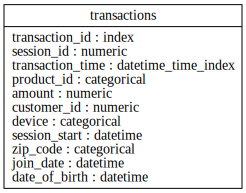

In [27]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])
products_df = data["products"]

es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time")
es.plot()

Notice how the variable type of **`session_id`** is Numeric, and the variable type of **`session_start`** is Datetime. 

Now let's normalize the entity to create a new entity, based on the transactions entity.

2019-06-20 15:02:30,139 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: transactions.session_id -> sessions.session_id>


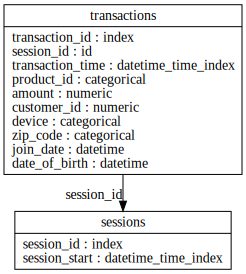

In [29]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["session_start"])
es.plot()

The type for **`session_id`** is now `Id` in `transactions` entity, and `Index` in the new entity of `sessions`. This is because when we normalize the entity, we create a new relationship between the `transactions` and `sessions`. There is a one to many relationship between the parent entity of `sessions` and child entity of `transactions`.

Therefore, `session_id` becomes an `Id` type in `transactions` because it represents an `Index` in another entity. A similar thing would happen if we added another entity using `entity_from_dataframe` and `add_relationship`. 

In addition, when we created the new entity, we specified a `time_index` which was the variable (column) **`session_start`**. This changed to a `datetime_time_index` in the new **`sessions`** entity because it now represents a time_index.

## How do select a certain amount of past data when calculating features?

You may encounter a situation when you wish to make prediction using only a certain amount of historical data. You can accomplish this using the `training_window` parameter in `ft.dfs`. When you use the `training_window`, Featuretools will use the historical data between the `cutoff time` and `cutoff_time - training_window`.

In order to make the calculation, Featuretools will check the time in the `time_index` column of the `target_entity`.

In [36]:
es = ft.demo.load_mock_customer(return_entityset=True)
es['customers'].time_index

'join_date'

Our target_entity, has a `time_index`, which is needed for the `training_window` calculation.

In [38]:
cutoff_times = pd.DataFrame()
cutoff_times['customer_id'] = [1, 2, 3, 1]
cutoff_times['time'] = pd.to_datetime(['2014-1-1 04:00', '2014-1-1 05:00', '2014-1-1 06:00', '2014-1-1 08:00'])
cutoff_times['label'] = [True, True, False, True]

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      cutoff_time=cutoff_times,
                                      cutoff_time_in_index=True,
                                      training_window="1 hour")

## Why I am getting the following warning 'Using training_window but last_time_index is not set'?

If you are using training window, and you haven't set a `last_time_index` for you entity, you will get this warning.
The training window in Featuretools limits the amount of past data that can be used while calculating a particular feature vector. For example, let's say a customer's has multiple sessions. To determine the amount of historical data to use, we need to make sure Featuretools knows when a session starts, and when a session ends. 

You can add the `last_time_index` to all entities automatically by calling `your_entityset.add_last_time_indexes()` after you create your EntitySet. This will remove the warning.

The l`ast_time_index` is used so we can exclude rows that have their last data before the start of the window of training data. This is different than `time_index`, which makes sure the row was known or had its first data before the end of the window of training data.

In [48]:
es = ft.demo.load_mock_customer(return_entityset=True)
es.add_last_time_indexes()

In [49]:
cutoff_times = pd.DataFrame()
cutoff_times['customer_id'] = [1, 2, 3, 1]
cutoff_times['time'] = pd.to_datetime(['2014-1-1 04:00', '2014-1-1 05:00', '2014-1-1 06:00', '2014-1-1 08:00'])
cutoff_times['label'] = [True, True, False, True]

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      cutoff_time=cutoff_times,
                                      cutoff_time_in_index=True,
                                      training_window="1 hour")

## How do I apply DFS to a single table?

You can run DFS on a single table. Featuretools will be able to generate features for you data, but they will only be transform features. 

For example:

In [67]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"]

es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time")

feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_entity="transactions", 
                                      trans_primitives=['time_since', 'day', 'is_weekend', 
                                                        'cum_min', 'minute', 'days_since', 
                                                        'num_words', 'weekday', 'cum_count', 
                                                        'percentile', 'year', 'week',
                                                        'cum_mean'])

Let's look at our original table.

In [68]:
transactions_df.head()

,transaction_id,session_id,transaction_time,product_id,amount
0,298,1,2014-01-01 00:00:00,5,127.64
1,2,1,2014-01-01 00:01:05,2,109.48
2,308,1,2014-01-01 00:02:10,3,95.06
3,116,1,2014-01-01 00:03:15,4,78.92
4,371,1,2014-01-01 00:04:20,3,31.54


Now we can look at the transformations that Featuretools was able to apply to this single entity (table).

In [71]:
feature_matrix.head()

,session_id,product_id,amount,DAY(transaction_time),IS_WEEKEND(transaction_time),CUM_MIN(session_id),CUM_MIN(amount),MINUTE(transaction_time),DAYS_SINCE(transaction_time),WEEKDAY(transaction_time),...,PERCENTILE(CUM_MIN(session_id)),PERCENTILE(CUM_MIN(amount)),PERCENTILE(MINUTE(transaction_time)),PERCENTILE(DAYS_SINCE(transaction_time)),CUM_MEAN(CUM_MIN(session_id)),CUM_MEAN(CUM_MIN(amount)),CUM_MEAN(MINUTE(transaction_time)),CUM_MEAN(DAYS_SINCE(transaction_time)),CUM_MEAN(PERCENTILE(session_id)),CUM_MEAN(PERCENTILE(amount))
transaction_id,,,,,,,,,,,,,,,,,,,,,
1,31,2,21.77,1,False,1,5.73,43,1996,2,...,0.501,0.321,0.725,0.501,1.0,7.511166,28.720280,1996.0,0.430075,0.507935
2,1,2,109.48,1,False,1,109.48,1,1996,2,...,0.501,0.998,0.027,0.501,1.0,118.560000,0.500000,1996.0,0.017000,0.793000
3,35,3,62.49,1,False,1,5.73,44,1996,2,...,0.501,0.321,0.742,0.501,1.0,7.305505,28.886598,1996.0,0.486031,0.504231
4,30,3,7.55,1,False,1,5.73,31,1996,2,...,0.501,0.321,0.526,0.501,1.0,7.558038,28.480861,1996.0,0.419108,0.505258
5,4,2,126.80,1,False,1,6.29,10,1996,2,...,0.501,0.826,0.178,0.501,1.0,16.696667,25.681818,1996.0,0.067000,0.496621


## How do I prevent label leakdage with DFS?

One concern you might have with using DFS is about label leakage. You want to make sure that information from outside the train dataset (such as information from the test dataset) isn't used to create the predictive model. Featuretools is particularly focused on helping users avoid label leakage. There are two ways to deal with data leakage depending on if you have timestamps or not.

### 1. Data without timestamps

In the case where you don’t have timestamps, you can create one `EntitySet` using only the training data and then run `ft.dfs`. This will create a feature matrix using only the training data, but also return a list of feature definitions. Next, you can create an `EntitySet` using the test data and recalculate the same features by calling `ft.calculate_feature_matrix` with the list of feature definitions from before. 

Here is what that flow would look like:

In [81]:
es_train = ft.demo.load_mock_customer(return_entityset=True)


feature_matrix_train, feature_defs = ft.dfs(entityset=es_train, 
                                      target_entity="customers")

feature_matrix_train_enc, features_enc = ft.encode_features(feature_matrix_train, feature_defs)
feature_matrix_train_enc

,zip_code = 60091,zip_code = 13244,zip_code is unknown,COUNT(sessions),NUM_UNIQUE(sessions.device),MODE(sessions.device) = mobile,MODE(sessions.device) = desktop,MODE(sessions.device) is unknown,SUM(transactions.amount),STD(transactions.amount),...,MODE(sessions.MODE(transactions.product_id)) = 4,MODE(sessions.MODE(transactions.product_id)) is unknown,MODE(sessions.DAY(session_start)) = 1,MODE(sessions.DAY(session_start)) is unknown,MODE(sessions.YEAR(session_start)) = 2014,MODE(sessions.YEAR(session_start)) is unknown,MODE(sessions.MONTH(session_start)) = 1,MODE(sessions.MONTH(session_start)) is unknown,MODE(sessions.WEEKDAY(session_start)) = 2,MODE(sessions.WEEKDAY(session_start)) is unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,8,3,1,0,0,9025.62,40.442059,...,1,0,1,0,1,0,1,0,1,0
2,0,1,0,7,3,0,1,0,7200.28,37.705178,...,0,0,1,0,1,0,1,0,1,0
3,0,1,0,6,3,0,1,0,6236.62,43.683296,...,0,0,1,0,1,0,1,0,1,0
4,1,0,0,8,3,1,0,0,8727.68,45.068765,...,0,0,1,0,1,0,1,0,1,0
5,1,0,0,6,3,1,0,0,6349.66,44.095630,...,0,0,1,0,1,0,1,0,1,0


In [82]:
es_test = ft.demo.load_mock_customer(return_entityset=True, random_seed=33)
feature_matrix_test = ft.calculate_feature_matrix(features=features_enc, entityset=es_test)
feature_matrix_test

,zip_code = 60091,zip_code = 13244,zip_code is unknown,COUNT(sessions),NUM_UNIQUE(sessions.device),MODE(sessions.device) = mobile,MODE(sessions.device) = desktop,MODE(sessions.device) is unknown,SUM(transactions.amount),STD(transactions.amount),...,MODE(sessions.MODE(transactions.product_id)) = 4,MODE(sessions.MODE(transactions.product_id)) is unknown,MODE(sessions.DAY(session_start)) = 1,MODE(sessions.DAY(session_start)) is unknown,MODE(sessions.YEAR(session_start)) = 2014,MODE(sessions.YEAR(session_start)) is unknown,MODE(sessions.MONTH(session_start)) = 1,MODE(sessions.MONTH(session_start)) is unknown,MODE(sessions.WEEKDAY(session_start)) = 2,MODE(sessions.WEEKDAY(session_start)) is unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
1,True,False,False,6,3,False,True,False,5776.41,41.998795,...,True,False,True,False,True,False,True,False,True,False
2,False,True,False,8,3,False,True,False,9877.67,39.913352,...,False,False,True,False,True,False,True,False,True,False
3,True,False,False,5,2,True,False,False,5258.95,42.416322,...,False,False,True,False,True,False,True,False,True,False
4,False,True,False,9,3,False,True,False,10178.43,36.523849,...,False,False,True,False,True,False,True,False,True,False
5,True,False,False,7,3,False,True,False,9018.74,37.514054,...,False,False,True,False,True,False,True,False,True,False


### 2. Data with timestamps

If your data has timestamps, the best way to prevent leakage is to use a list of **cutoff times**, which specify the last point in time data is allowed to be used for each row in the resulting feature matrix. To use **cutoff times**, you need to set a time index for each time sensitive entity in your entity set.

Tip: Even if your data doesn’t have time stamps, you could add a column with dummy timestamps that can be used by Featuretools as time index.

When you call `ft.dfs`, you can provide a dataframe of cutoff times like this:

In [83]:
cutoff_times = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                             "time": pd.date_range('2014-01-01 01:41:50', periods=5, freq='25min')})
cutoff_times

,customer_id,time
0,1,2014-01-01 01:41:50
1,2,2014-01-01 02:06:50
2,3,2014-01-01 02:31:50
3,4,2014-01-01 02:56:50
4,5,2014-01-01 03:21:50


In [84]:
es_train_test = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, features = ft.dfs(entityset=es_train_test,
                                  target_entity="customers",
                                  cutoff_time=cutoff_times,
                                  cutoff_time_in_index=True)

## How split my data into test & train after running DFS?
